# INDE 599 hw 4

## Ch14 - Exercise3

*If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?*

* Reduce the mini-batch size. 
* Reduce dimensionality using a larger stride in one or more layers. 
* Remove one or more layers.
* Use 16-bit floats instead of 32-bit floats.
* Distribute the CNN across multiple devices.

## Ch14 - Exercise9

*Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.*

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import numpy as np

In [ ]:
def refresh():
  keras.backend.clear_session()
  np.random.seed(599)
  tf.random.set_seed(599)

Confirm if we are connected to the GPU with tensorflow (ref: <https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2>):

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Generating datasets

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

`np.newaxis` is used to increase the dimension of the existing array by one more dimension, when used once. For example, 1D array will become 2D array and here in our case, 2D array will become 3D array.

In [ ]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

 Alternatively you can use the code below for the same function:

In [ ]:
newaxes = -1 # index of the new dimension. Use newaxes = (0, 3, -1) for more dimensions
X_train = np.expand_dims(X_train, axis=newaxes)
X_valid = np.expand_dims(X_valid, axis=newaxes)
X_test = np.expand_dims(X_test, axis=newaxes)

### Building the model
The model directly used a VGG16 structure with three sets of two convolutional layers plus a pooling layer, plus a final dense network with two hidden layers and the output layer. Only 3x3 filters were applied.

In [ ]:
refresh()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(64, 3, activation='relu', input_shape=(28,28,1)))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, activation='relu'))
model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       147584    
                                                        

### Model compiling, training and evaluating

`accuracy` will automatically decide which metrics `categorical_accuracy` or `sparse_categorical_accuracy` to use. The former requires one-hot input and the later requires a single vector with each number representing a category.

* Try optimizer `nadam`

In [ ]:
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, epochs=100, validation_data= (X_valid, y_valid),  callbacks=[earlystop_callback])

Epoch 1/100
1719/1719 [==============================] - 31s 10ms/step - loss: 0.1337 - accuracy: 0.9590 - val_loss: 0.0447 - val_accuracy: 0.9884
Epoch 2/100
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0458 - accuracy: 0.9865 - val_loss: 0.0345 - val_accuracy: 0.9916
Epoch 3/100
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0351 - accuracy: 0.9897 - val_loss: 0.0310 - val_accuracy: 0.9908
Epoch 4/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0286 - accuracy: 0.9915 - val_loss: 0.0549 - val_accuracy: 0.9862
Epoch 5/100
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0293 - val_accuracy: 0.9922
Epoch 6/100
1719/1719 [==============================] - 16s 10ms/step - loss: 0.0208 - accuracy: 0.9940 - val_loss: 0.0437 - val_accuracy: 0.9908
Epoch 7/100
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0205 - accuracy: 0.9937 - val_loss: 0.0

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0391 - accuracy: 0.9898


[0.03905110061168671, 0.989799976348877]

* Try optimizer `RMSprop`

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, epochs=100, validation_data= (X_valid, y_valid),  callbacks=[earlystop_callback])

model.evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
1719/1719 [==============================] - 17s 9ms/step - loss: 0.0169 - accuracy: 0.9964 - val_loss: 0.0317 - val_accuracy: 0.9942
Epoch 2/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0152 - accuracy: 0.9967 - val_loss: 0.0574 - val_accuracy: 0.9954
Epoch 3/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0142 - accuracy: 0.9972 - val_loss: 0.0727 - val_accuracy: 0.9938
Epoch 4/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0154 - accuracy: 0.9974 - val_loss: 0.0444 - val_accuracy: 0.9926
Epoch 5/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0187 - accuracy: 0.9971 - val_loss: 0.0624 - val_accuracy: 0.9926
Epoch 6/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0343 - accuracy: 0.9921


[0.03427254408597946, 0.9921000003814697]

The optimizer `RMSprop` method outperformed `Nadam` with an accuracy rate 99.21% on test set. Try other learning rates
with both optimizer (`learning_rate = 0.001` by default). 

Since the GPU is limited and it seems whether the results worked well can be seen from the first one or two epoches. I tried different learning rates including 0.01, 0.03, 0.05, 0.001, 0.005, 0.003, 0.0005, 0.0003 for only one or two epoches and finally decided to use 0.0003 for both optimizers. 

I also tried the optimizer `adam`, it did not gives us a comparable better results as these two optimizers. Therefore, I only kept with the two optimizers.

In [ ]:
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, epochs=100, validation_data= (X_valid, y_valid),  callbacks=[earlystop_callback])

model.evaluate(X_test, y_test)

Epoch 1/100
1719/1719 [==============================] - 16s 9ms/step - loss: 0.0334 - accuracy: 0.9922 - val_loss: 0.0354 - val_accuracy: 0.9932
Epoch 2/100
1719/1719 [==============================] - 15s 8ms/step - loss: 0.0250 - accuracy: 0.9935 - val_loss: 0.0219 - val_accuracy: 0.9932
Epoch 3/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0200 - accuracy: 0.9945 - val_loss: 0.0228 - val_accuracy: 0.9950
Epoch 4/100
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0176 - accuracy: 0.9955 - val_loss: 0.0248 - val_accuracy: 0.9944
Epoch 5/100
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0177 - accuracy: 0.9951 - val_loss: 0.0340 - val_accuracy: 0.9940
Epoch 6/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.0268 - val_accuracy: 0.9940
Epoch 7/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0279 - accuracy: 0.9932


[0.027930080890655518, 0.9932000041007996]

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, epochs=100, validation_data= (X_valid, y_valid),  callbacks=[earlystop_callback])

model.evaluate(X_test, y_test)

Epoch 1/100
1719/1719 [==============================] - 14s 8ms/step - loss: 0.0470 - accuracy: 0.9915 - val_loss: 0.0311 - val_accuracy: 0.9920
Epoch 2/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0480 - accuracy: 0.9917 - val_loss: 0.1455 - val_accuracy: 0.9918
Epoch 3/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0466 - accuracy: 0.9913 - val_loss: 0.1319 - val_accuracy: 0.9910
Epoch 4/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0488 - accuracy: 0.9911 - val_loss: 0.0336 - val_accuracy: 0.9914
Epoch 5/100
1719/1719 [==============================] - 13s 8ms/step - loss: 0.0456 - accuracy: 0.9910 - val_loss: 0.0466 - val_accuracy: 0.9894
Epoch 6/100
313/313 [==============================] - 1s 4ms/step - loss: 0.0513 - accuracy: 0.9906


[0.05125371739268303, 0.9905999898910522]

The good news is that using optimizer `Nadam` with a learning rate of 0.0003 gave us an accuracy rate of 99.32% on the test set. 

## Ch14 - Exercise10

*Use transfer learning for large image classification, going through these steps:*

1. *Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).*

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

The dataset selected is the "23 Pet Breeds Image Classification"(<https://www.kaggle.com/datasets/aseemdandgaval/23-pet-breeds-image-classification>) from Kaggle. I only chose the eight cat breeds out of the 23 pet breeds. Each of the classes has 170 images except the mumbai cat class which contains 141. All the images are in .jpg/.jpeg format.

In [ ]:
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/")

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg'))) + len(list(data_dir.glob('*/*.JPG'))) + len(list(data_dir.glob('*/*.JPEG'))) 
print(image_count)

1287


In [ ]:
abyssinian= list(data_dir.glob('abyssinian/*'))
PIL.Image.open(str(abyssinian[0]))

Output hidden; open in https://colab.research.google.com to view.

2. *Split it into a training set, a validation set, and a test set.*

  Split the raw dataset into training set (80%), validation set (10%) and test set (10%). 

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=599,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 1287 files belonging to 8 classes.
Using 1030 files for training.


In [ ]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=599,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 1287 files belonging to 8 classes.
Using 257 files for validation.


`take` selects the initial N elements from the dataset; `skip` skips the initial N elements from the dataset. Here we cannot use `ceil(257/2)` since the take and skip will take and skip in batches. 

In [ ]:
257/32/2

4.015625

In [ ]:
val_ds = val_test_ds.take(4)
test_ds = val_test_ds.skip(4)

In [ ]:
class_names = train_ds.class_names
print(class_names)

['abyssinian', 'american shorthair', 'maine coon', 'mumbai cat', 'persian cat', 'ragdoll cat', 'siamese cat', 'sphynx']


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

InvalidArgumentError: ignored

<Figure size 720x720 with 0 Axes>

Some images are not in requred format (one of JPEG, PNG, GIF, BMP required). Check the format of the image files: 

In [ ]:
import os
import cv2
import imghdr

def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/' # set this to the directory with subfolders
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  abyssinian
processing class directory  american shorthair
processing class directory  maine coon
processing class directory  mumbai cat
file  /content/drive/MyDrive/Colab Notebooks/Pet_Breeds/mumbai cat/mumbai cat_71.jpg  is not a valid image file
processing class directory  persian cat
processing class directory  ragdoll cat
processing class directory  siamese cat
processing class directory  sphynx
improper image files are listed below
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_14.jpg
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_82.jpg
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_43.jpg
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_61.jpg
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/american shorthair/american shorthair_66.jpg
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/american shorthair/american shorthair_155.jpg
/content/drive/MyDrive/C

The filenames of the images not in required format are listed in `bad_file_list`, since we will have more than 100 samples for each category, we directly removed those images:

In [ ]:
import os
for img in bad_file_list:
    print(img)
    print('-----')
    os.remove(img)
    print(f"Deleted the {img} from your hardrive")

/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_14.jpg
-----
Deleted the /content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_14.jpg from your hardrive
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_82.jpg
-----
Deleted the /content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_82.jpg from your hardrive
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_43.jpg
-----
Deleted the /content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_43.jpg from your hardrive
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_61.jpg
-----
Deleted the /content/drive/MyDrive/Colab Notebooks/Pet_Breeds/abyssinian/abyssinian_61.jpg from your hardrive
/content/drive/MyDrive/Colab Notebooks/Pet_Breeds/american shorthair/american shorthair_66.jpg
-----
Deleted the /content/drive/MyDrive/Colab Notebooks/Pet_Breeds/american shorthair/american shorthair_66.jpg from your ha

Load the data again and view the images:

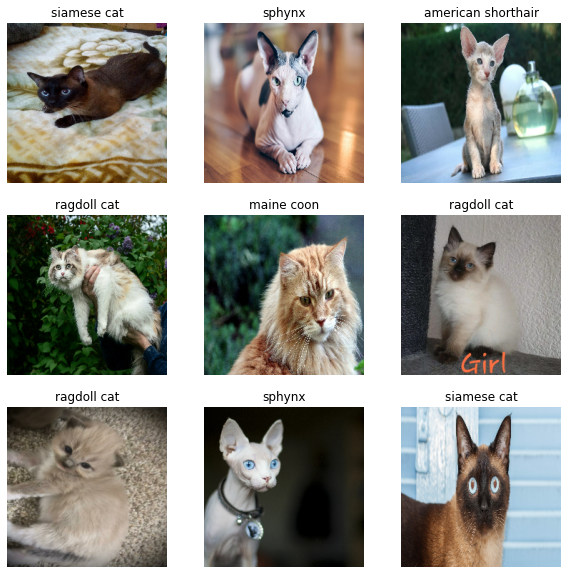

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


3. *Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.*

  The `image_batch` is a tensor of the shape `(32, 224, 224, 3)`. This is a batch of 32 images of shape `224x224x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. We can see the images are already resized to our desired size (we have set this when loading the data).

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

The `next()` function returns the next item from the iterator.

In [ ]:
train_norm_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_norm_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
val_norm_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(val_norm_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0064011184 1.0


In [ ]:
test_norm_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(test_norm_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_norm_ds = train_norm_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_norm_ds = val_norm_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_norm_ds = test_norm_ds.prefetch(buffer_size=AUTOTUNE)

4. *Fine-tune a pretrained model on this dataset.*

In [ ]:
n_classes = 8
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [ ]:
from ssl import CERT_OPTIONAL
from math import ceil
for layer in base_model.layers:
    layer.trainable = False

dataset_size = image_count

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_norm_ds,
                    steps_per_epoch=ceil(0.80 * dataset_size / batch_size),
                    validation_data=val_norm_ds,
                    validation_steps=ceil(0.10 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
33/33 [==============================] - 10s 255ms/step - loss: 0.9918 - accuracy: 0.8262 - val_loss: 1.3099 - val_accuracy: 0.7688
Epoch 2/5
33/33 [==============================] - 8s 239ms/step - loss: 1.0203 - accuracy: 0.8369 - val_loss: 2.3310 - val_accuracy: 0.7563
Epoch 3/5
33/33 [==============================] - 8s 240ms/step - loss: 0.9026 - accuracy: 0.8583 - val_loss: 4.1373 - val_accuracy: 0.6750
Epoch 4/5
33/33 [==============================] - 8s 241ms/step - loss: 0.7059 - accuracy: 0.8903 - val_loss: 1.7895 - val_accuracy: 0.8000
Epoch 5/5
33/33 [==============================] - 8s 241ms/step - loss: 0.3979 - accuracy: 0.9184 - val_loss: 1.7353 - val_accuracy: 0.7937


Change the learning rate to 0.05 and train again with Earlystop callback:

In [ ]:
from ssl import CERT_OPTIONAL
from math import ceil
for layer in base_model.layers:
    layer.trainable = False

dataset_size = image_count

optimizer = keras.optimizers.SGD(learning_rate=0.05, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(train_norm_ds,
                    steps_per_epoch=ceil(0.80 * dataset_size / batch_size),
                    validation_data=val_norm_ds,
                    validation_steps=ceil(0.10 * dataset_size / batch_size),
                    epochs=40,
                    callbacks = [earlystop_callback])

Epoch 1/40
33/33 [==============================] - 57s 256ms/step - loss: 0.0204 - accuracy: 0.9932 - val_loss: 0.9977 - val_accuracy: 0.8188
Epoch 2/40
33/33 [==============================] - 8s 250ms/step - loss: 0.0186 - accuracy: 0.9932 - val_loss: 1.1974 - val_accuracy: 0.8188
Epoch 3/40
33/33 [==============================] - 8s 232ms/step - loss: 0.0153 - accuracy: 0.9922 - val_loss: 0.9214 - val_accuracy: 0.8562
Epoch 4/40
33/33 [==============================] - 8s 230ms/step - loss: 0.0136 - accuracy: 0.9922 - val_loss: 1.2472 - val_accuracy: 0.8375
Epoch 5/40
33/33 [==============================] - 8s 230ms/step - loss: 0.0128 - accuracy: 0.9922 - val_loss: 1.0696 - val_accuracy: 0.8813
Epoch 6/40
33/33 [==============================] - 8s 232ms/step - loss: 0.0123 - accuracy: 0.9922 - val_loss: 0.9999 - val_accuracy: 0.8500
Epoch 7/40
33/33 [==============================] - 8s 231ms/step - loss: 0.0119 - accuracy: 0.9922 - val_loss: 1.1921 - val_accuracy: 0.8313
Epoch

The model performs well with an accuracy rate of 99.22% on training set, 85% on validation set and 80.62% on test set.

In [ ]:
model.evaluate(test_norm_ds)

5/5 [==============================] - 3s 100ms/step - loss: 1.5061 - accuracy: 0.8062


[1.5060826539993286, 0.8062015771865845]

## Ch14 - Exercise11

*Go through TensorFlow’s Style Transfer tutorial. It is a fun way to generate art using Deep Learning.*

Neural style transfer is an optimization technique used to take two images

- a content image
- a style reference image (such as an artwork by a famous painter) 

Blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

In [ ]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

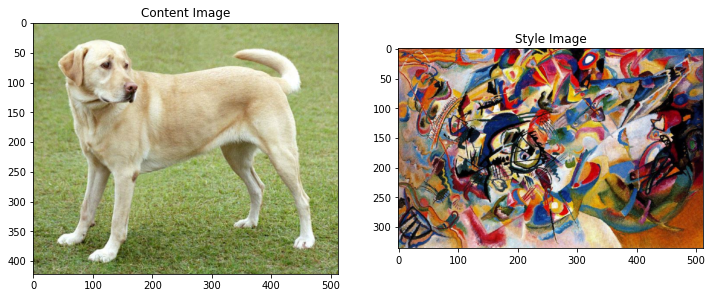

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

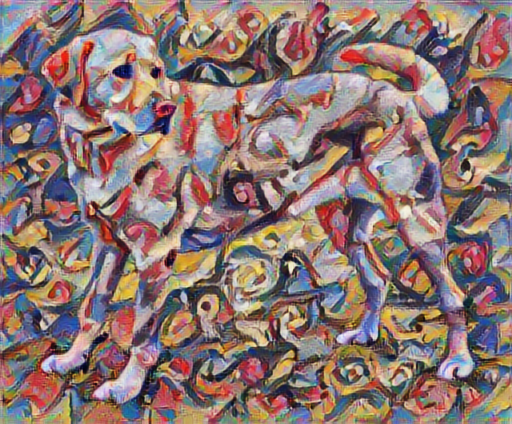

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Try another style image:

In [ ]:
style_path = tf.keras.utils.get_file('Der-Lebensbaum-Mittelteil-Ausschnitt-1.jpg','https://www.art-prints-on-demand.com/kunst/gustav_klimt/Der-Lebensbaum-Mittelteil-Ausschnitt-1.jpg')

245760/231176 [===============================] - 0s 1us/step


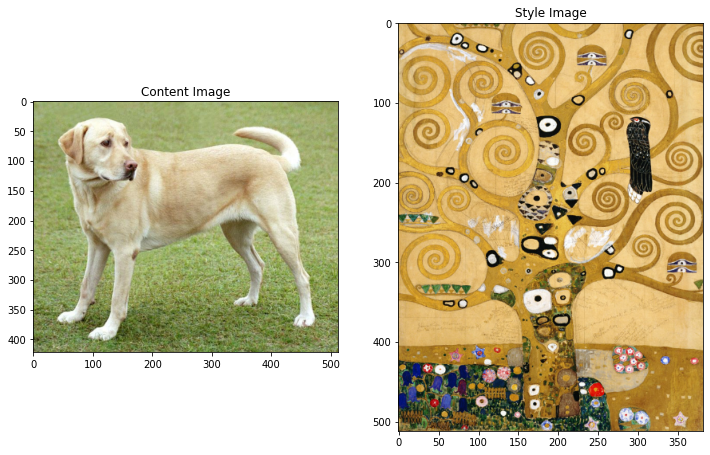

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

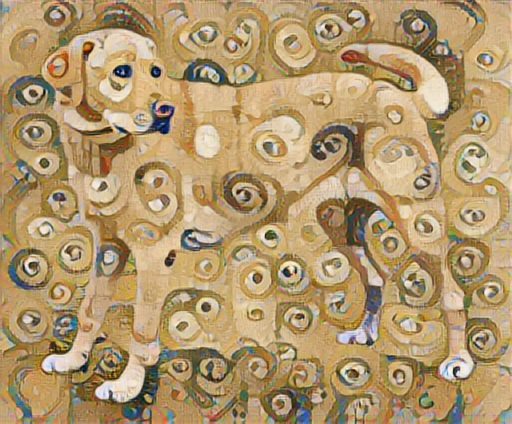

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

### Define content and style representations

In [ ]:
# VGG19
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574726144/574710816 [==============================] - 3s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

49152/35363 [=========================================] - 0s 0us/step


[('Labrador_retriever', 0.49317136),
 ('golden_retriever', 0.23665282),
 ('kuvasz', 0.036357533),
 ('Chesapeake_Bay_retriever', 0.024182757),
 ('Greater_Swiss_Mountain_dog', 0.01864606)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Group the layers. Choose intermediate layers from the network to represent the style and content of the image:

In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Build the model
This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

Create the model:

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 382, 64)
  min:  0.0
  max:  843.4846
  mean:  39.245914

block2_conv1
  shape:  (1, 256, 191, 128)
  min:  0.0
  max:  4951.0386
  mean:  194.86748

block3_conv1
  shape:  (1, 128, 95, 256)
  min:  0.0
  max:  12490.211
  mean:  203.0122

block4_conv1
  shape:  (1, 64, 47, 512)
  min:  0.0
  max:  35557.434
  mean:  770.01776

block5_conv1
  shape:  (1, 32, 23, 512)
  min:  0.0
  max:  4294.5737
  mean:  65.68257



### Calculate styles
The content of an image is represented by the values of the intermediate feature maps.

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

### Extract styles and content
Build a model that returns the style and content tensors.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.37
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


### Run gradient descent

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Initialize the variable:

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Run a few steps to test:

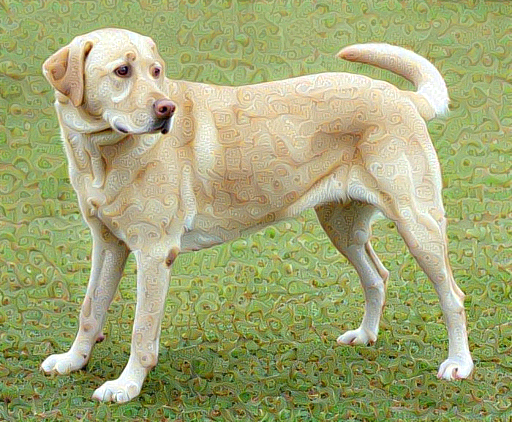

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

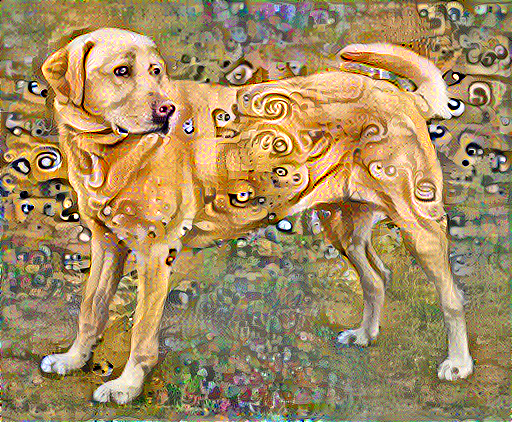

Train step: 1000
Total time: 74.3


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

### Total variation loss
One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

This shows how the high frequency components have increased.

Also, this high frequency component is basically an edge-detector. You can get similar output from the Sobel edge detector, for example

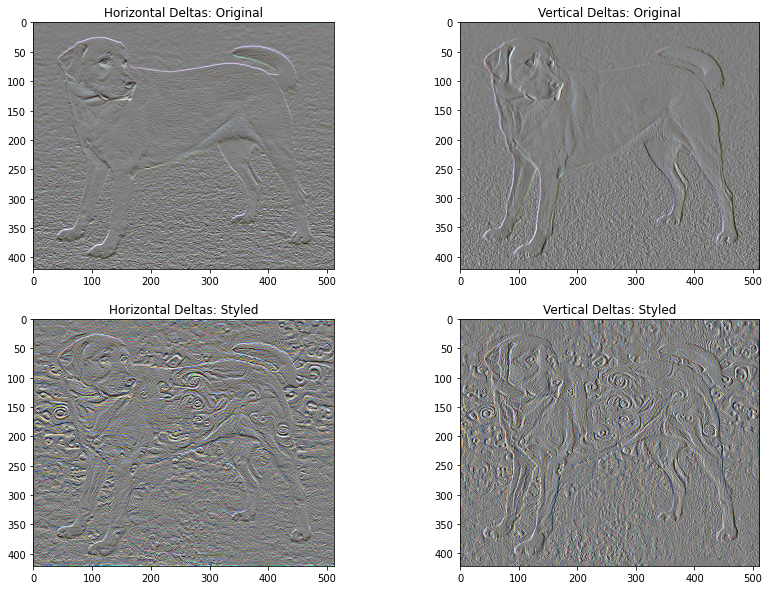

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

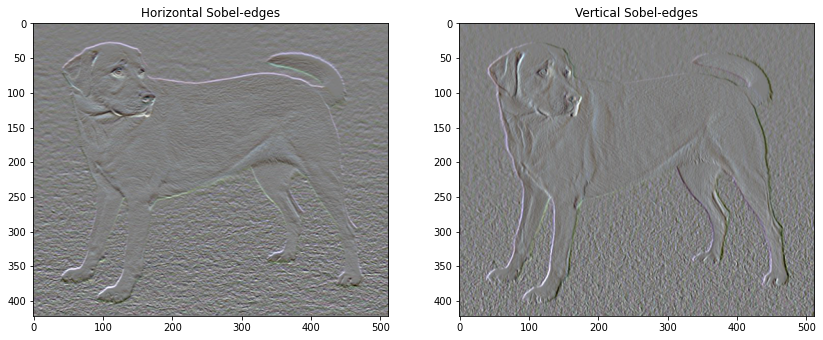

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

131243.75

Alternatively, you can directly use the method provided by TensorFlow:

In [ ]:
tf.image.total_variation(image).numpy()

array([131243.75], dtype=float32)

### Re-run the optimization
Include the `total_variation_weight` to the `train_step` function.

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the variable:

In [ ]:
image = tf.Variable(content_image)

Re-run the optimization:

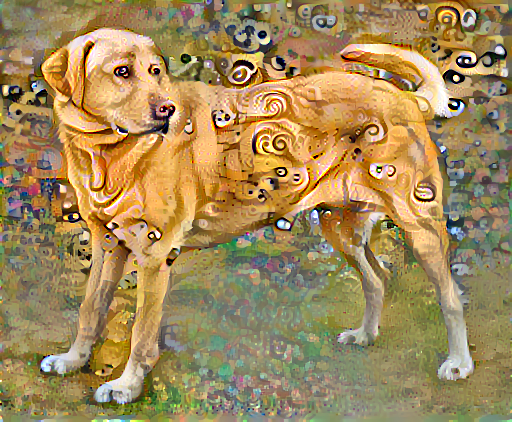

Train step: 1000
Total time: 77.1


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

### Save your stylized image

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>